In [1]:
# From WoFSCast
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

from wofscast import icosahedral_mesh, model_utils, square_mesh
from wofscast import grid_mesh_connectivity 
from wofscast.square_mesh import _ChildVerticesBuilder, TriangularMesh, merge_meshes

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import cartopy.crs as ccrs
from glob import glob
import math 

def _get_max_and_mean_edge_distance(mesh):
    senders, receivers = square_mesh.faces_to_edges(mesh.faces)
    edge_distances = np.linalg.norm(
      mesh.vertices[senders] - mesh.vertices[receivers], axis=-1)
    return edge_distances.max(), edge_distances.mean() 


In [2]:
positive_lon = True

# Positive longitude dataset 
year = '2021'
if positive_lon:
    base_path = '/work/mflora/wofs-cast-data/datasets_2hr_zarr/'
    fname = 'wrfwof_2021-05-15_020000_to_2021-05-15_041000__10min__ens_mem_09.zarr'

# Negative longitude dataset 
else:
    base_path = '/work2/mflora/wofscast_datasets/dataset_10min_updated/'
    fname = 'wrfwof_2021-05-15_001500_to_2021-05-15_022500__10min__ens_mem_01.zarr'

    
dataset = xr.open_zarr(os.path.join(base_path, year, fname), chunks={})

In [3]:
# Specification of the multimesh.
mesh_size=5
N=150

meshes = (
        square_mesh.get_hierarchy_of_triangular_meshes(
            splits=mesh_size, domain_size=N, tiling=None))
    
merged_meshes = square_mesh.merge_meshes(meshes)

finest_mesh = meshes[-1]

grid_lat = dataset['lat'].values
grid_lon = dataset['lon'].values
dataset.close()

mesh_nodes_lon, mesh_nodes_lat = square_mesh.get_mesh_coords(finest_mesh, grid_lat, grid_lon)

max_dist, mean_dist = _get_max_and_mean_edge_distance(finest_mesh)

print(f'Max distance on Finest Mesh: {max_dist*3:.1f}km')
print(f'Mean distance on Finest Mesh: {mean_dist*3:.1f}km')

Max distance on Finest Mesh: 13.7km
Mean distance on Finest Mesh: 11.0km


## NWP to MESH connections

Total number of connections: 1061
Expected number of connections based on radius 3.0: 1061


<Axes: title={'center': 'Grid-Mesh Connectivity (Radius = 3.0)'}>

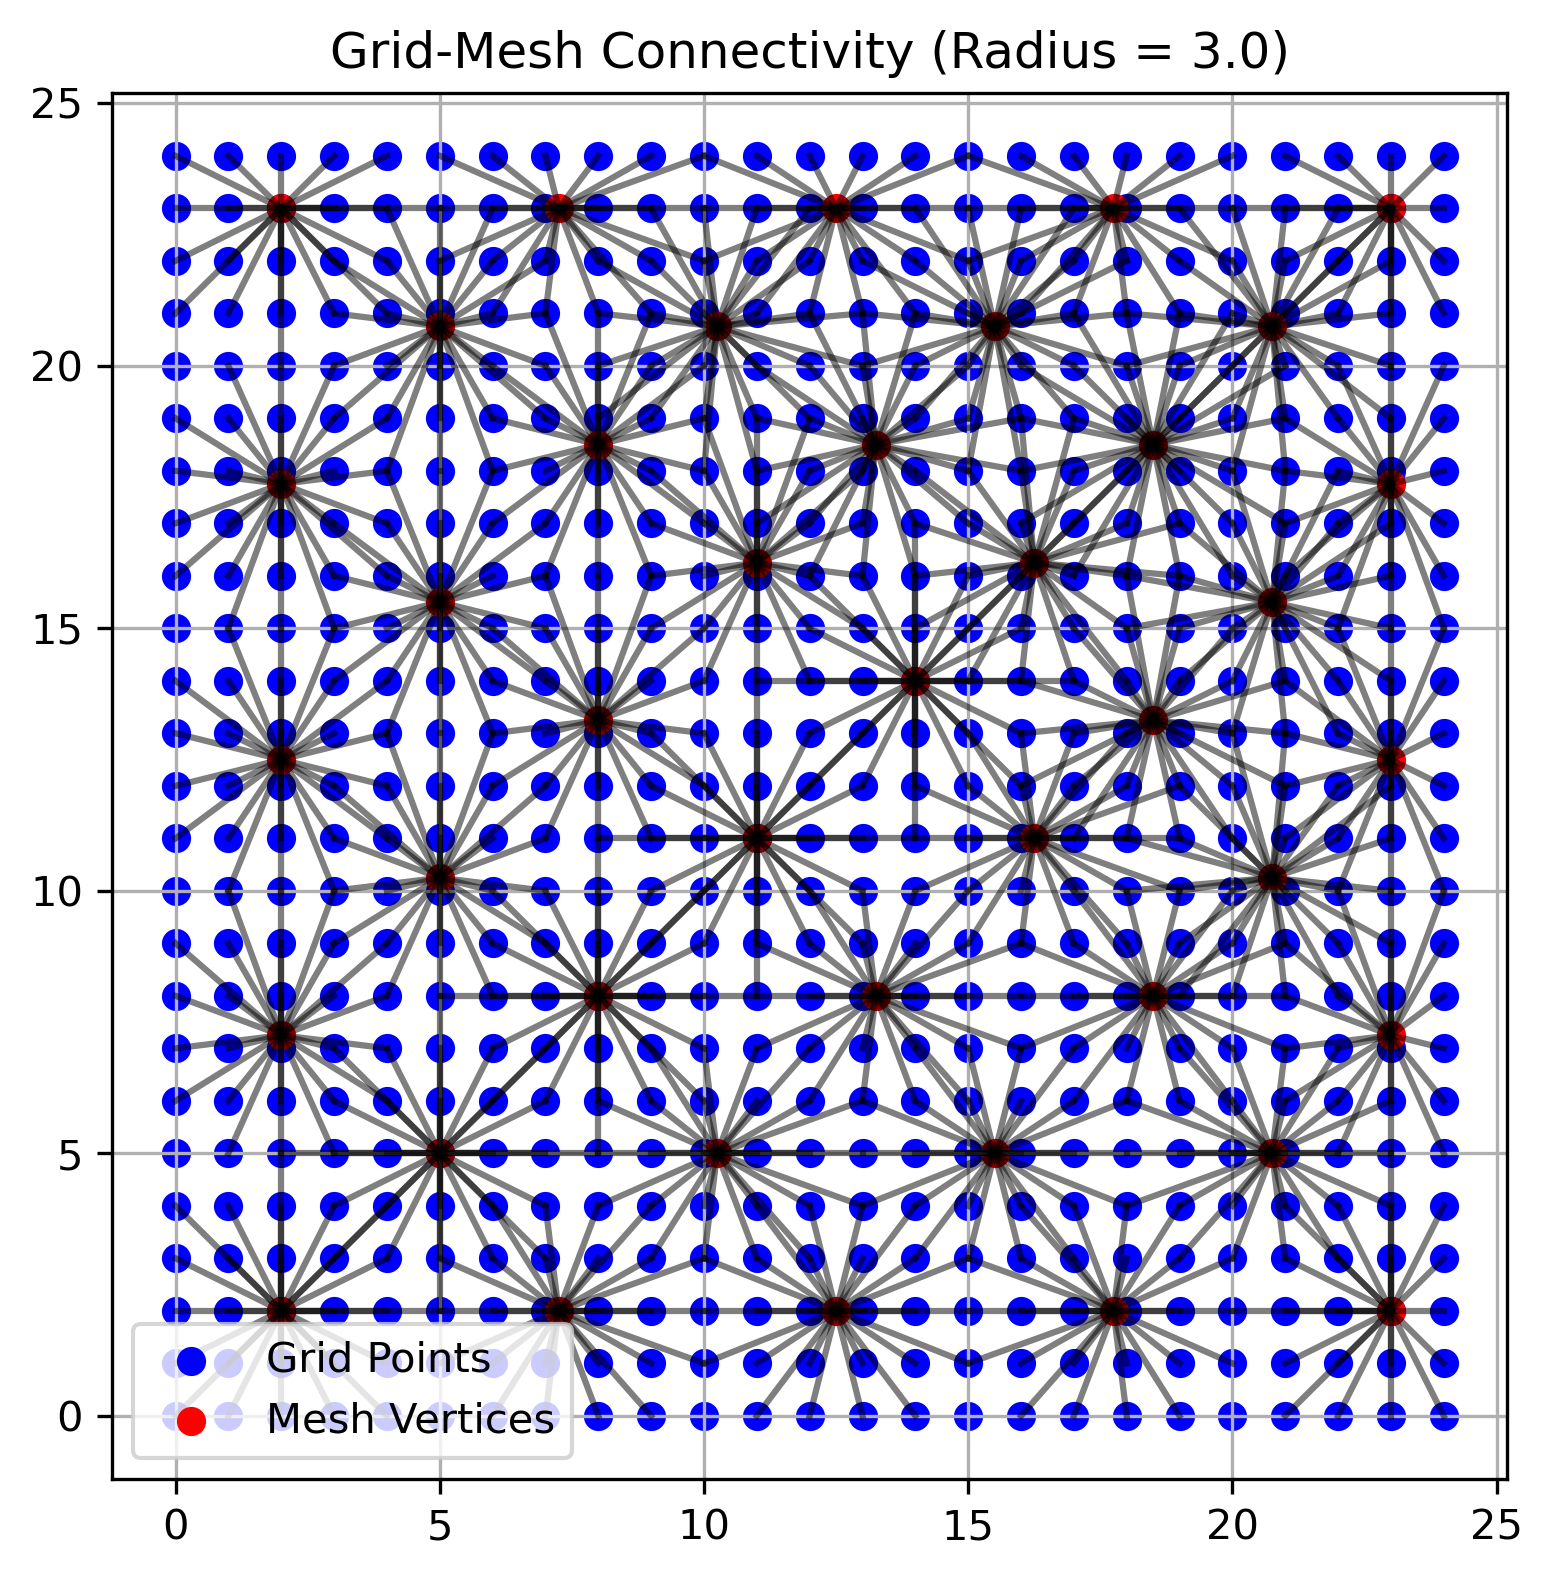

In [4]:
import scipy
def test_radius_query_indices(): 
    # Test works! Does not involve latitude or longitude, so positive
    # or negative longitude plays no role.
    
    grid_size = 25
    mesh_size = 2
    query_radius = 3.0
    meshes = (
        square_mesh.get_hierarchy_of_triangular_meshes(
            splits=mesh_size, domain_size=grid_size, tiling=None))
    
    finest_mesh = meshes[-1]

    # Radius is interpreted in the 3 km grid spacing distance. 
    grid_indices, mesh_indices = square_mesh.radius_query_indices(grid_size, finest_mesh, 
                                                              radius=query_radius)
    
    # Grid and mesh positions are defined arbitrary 0-N, 0-N grid;
    # does not consider latitude and longitude 
    grid_positions = square_mesh.get_grid_positions(grid_size)
    mesh_positions = finest_mesh.vertices
    
    # Check if number of connections is correct
    total_connections = len(grid_indices)
    print(f"Total number of connections: {total_connections}")
    
    # Distance calculation to verify the number of points within the query radius
    distances = scipy.spatial.distance.cdist(grid_positions, mesh_positions, 'euclidean')
    expected_connections = np.sum(distances <= query_radius)
    print(f"Expected number of connections based on radius {query_radius}: {expected_connections}")

    # Verify that the number of connections matches expected
    assert total_connections == expected_connections, (
        f"Number of connections ({total_connections}) doesn't match expected ({expected_connections}).")
    
    # Create the plot
    fig, ax = plt.subplots(dpi=300, figsize=(6, 6))
    ax.scatter(grid_positions[:, 0], grid_positions[:, 1], c='blue', label='Grid Points')
    ax.scatter(mesh_positions[:, 0], mesh_positions[:, 1], c='red', label='Mesh Vertices')
    ax.set(title=f'Grid-Mesh Connectivity (Radius = {query_radius})')
    
    # Plot the connectivity (edges)
    for grid_idx, mesh_idx in zip(grid_indices, mesh_indices):
        ax.plot(
            [grid_positions[grid_idx, 0], mesh_positions[mesh_idx, 0]],
            [grid_positions[grid_idx, 1], mesh_positions[mesh_idx, 1]],
            'k-', alpha=0.5  # line between grid and mesh points
        )
        
    ax.legend()
    ax.grid(True)
    
    return ax 
    
# Run the test
test_radius_query_indices()  
    

## Create edge features for Grid2Mesh 

In [5]:
def test_edge_features_grid2mesh():
    grid_size = 25
    mesh_size = 3
    query_radius = 2.0
    meshes = (
        square_mesh.get_hierarchy_of_triangular_meshes(
            splits=mesh_size, domain_size=grid_size, tiling=None))
    
    finest_mesh = meshes[-1]

    # Radius is interpreted in the 3 km grid spacing distance. 
    # These are the indices of the grid and mesh positions that are connected. 
    grid_indices, mesh_indices = square_mesh.radius_query_indices(grid_size, finest_mesh, 
                                                              radius=query_radius)
    
    spatial_features_kwargs = dict(
        add_node_positions=False,
        add_node_latitude=False,
        add_node_longitude=False,
        add_relative_positions=True,
        relative_longitude_local_coordinates=True,
        relative_latitude_local_coordinates=True,
    )

    # Edges sending info from grid to mesh.
    senders = grid_indices
    receivers = mesh_indices

    print(f'{senders.shape=}, {receivers.shape=}')

    # Initialize lat and lon for the grid.
    grid_nodes_lon, grid_nodes_lat = np.meshgrid(grid_lon, grid_lat)
    grid_nodes_lon = grid_nodes_lon.reshape([-1]).astype(np.float32)
    grid_nodes_lat = grid_nodes_lat.reshape([-1]).astype(np.float32)

    # Precompute structural node and edge features according to config options.
    # Structural features are those that depend on the fixed values of the
    # latitude and longitudes of the nodes.
    (senders_node_features, receivers_node_features,
     edge_features) = model_utils.get_bipartite_graph_spatial_features(
         senders_node_lat=grid_nodes_lat,
         senders_node_lon=grid_nodes_lon,
         receivers_node_lat=mesh_nodes_lat,
         receivers_node_lon=mesh_nodes_lon,
         senders=senders,
         receivers=receivers,
         edge_normalization_factor=None,
         **spatial_features_kwargs,
     )
    
    return edge_features
    
edge_features = test_edge_features_grid2mesh()   

senders.shape=(1756,), receivers.shape=(1756,)


## Test Mesh Edge Features

After correction: senders.shape=(280,), receivers.shape=(280,)
No redundant edges found.
All edges are bi-directional.


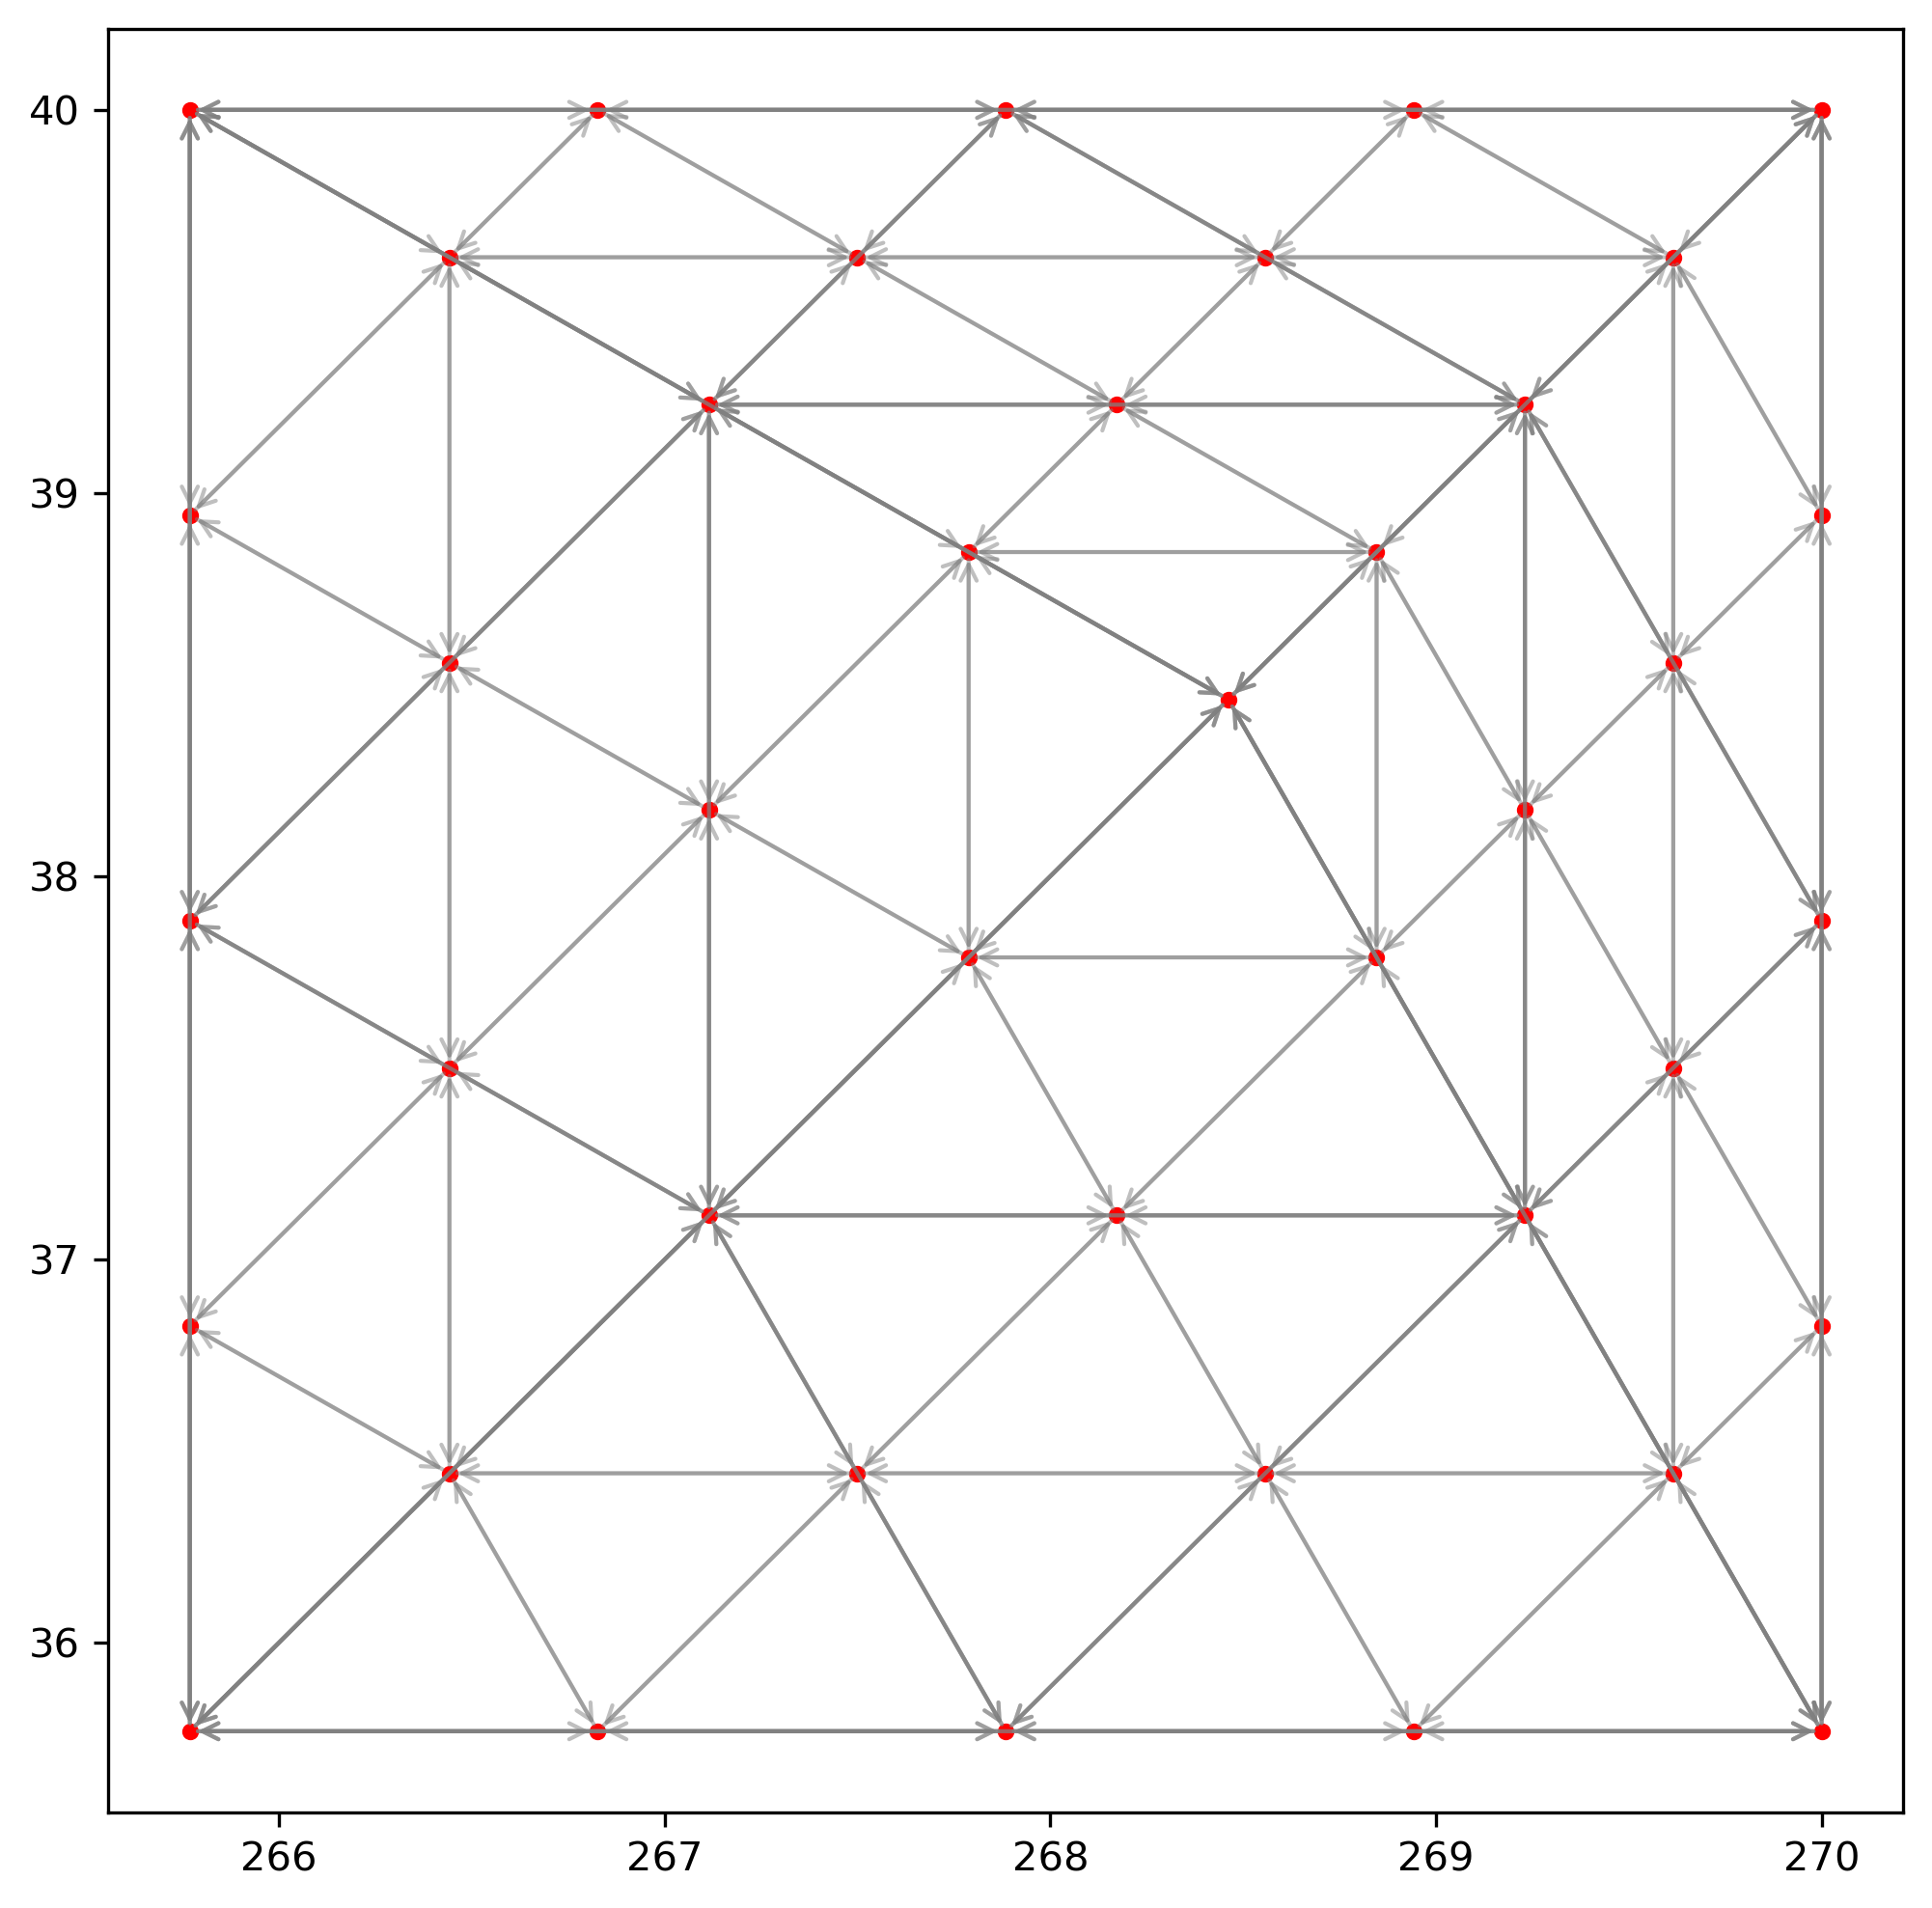

In [6]:
def check_redundant_edges(senders, receivers):
    edges = set()
    redundant_edges = []
    
    for sender, receiver in zip(senders, receivers):
        edge = (sender, receiver)
        
        if edge in edges:
            redundant_edges.append(edge)  # Add to redundant list
        else:
            edges.add(edge)
    
    if redundant_edges:
        print("Redundant edges found:", redundant_edges)
    else:
        print("No redundant edges found.")



def test_mesh_grid():
    spatial_features_kwargs = dict(
        add_node_positions=False,
        add_node_latitude=False,
        add_node_longitude=False,
        add_relative_positions=True,
        relative_longitude_local_coordinates=True,
        relative_latitude_local_coordinates=True,
    )
    
    grid_size = 15
    mesh_size = 2

    grid_lat = np.linspace(35, 40, grid_size)
    grid_lon = np.linspace(265, 270, grid_size, endpoint=True)
    
    meshes = (
        square_mesh.get_hierarchy_of_triangular_meshes(
            splits=mesh_size, domain_size=grid_size, tiling=None))

    finest_mesh = meshes[-1]
    merged_mesh = square_mesh.merge_meshes(meshes)

    # Work simply on the mesh edges.
    senders, receivers = square_mesh.faces_to_edges(merged_mesh.faces)

    print(f'After correction: {senders.shape=}, {receivers.shape=}')
    check_redundant_edges(senders, receivers)
    
    mesh_nodes_lon, mesh_nodes_lat = square_mesh.get_mesh_coords(finest_mesh, 
                                                                 grid_lat, grid_lon)
    
    node_features, edge_features = model_utils.get_graph_spatial_features(
        node_lat=mesh_nodes_lat,
        node_lon=mesh_nodes_lon,
        senders=senders,
        receivers=receivers,
        **spatial_features_kwargs,
    )
    
    # Bi-directionality check
    # Create a set of (sender, receiver) pairs
    edge_pairs = set(zip(senders, receivers))

    # Check if all edges are bi-directional
    bi_directional = True
    for sender, receiver in zip(senders, receivers):
        if (receiver, sender) not in edge_pairs:
            bi_directional = False
            print(f"Missing reverse edge for ({sender}, {receiver})")
    
    if bi_directional:
        print("All edges are bi-directional.")
    else:
        print("Some edges are not bi-directional.")

    # Create the plot
    fig, ax = plt.subplots(dpi=300, figsize=(8, 8))

    # Plot the grid and mesh nodes
    ax.scatter(mesh_nodes_lon, mesh_nodes_lat, color='red', label='Mesh Nodes', s=10)

    # Plot the connections between senders and receivers with arrows
    for sender, receiver in zip(senders, receivers):
        ax.annotate("",
                xy=(mesh_nodes_lon[receiver], mesh_nodes_lat[receiver]),
                xytext=(mesh_nodes_lon[sender], mesh_nodes_lat[sender]),
                arrowprops=dict(arrowstyle="->", color='gray', alpha=0.5))
        
test_mesh_grid()

## Test MESH2GRID Edge Features

In [8]:
def test_mesh2grid_edges(): 
    mesh2grid_edge_normalization_factor = None
    spatial_features_kwargs = dict(
        add_node_positions=False,
        add_node_latitude=False,
        add_node_longitude=False,
        add_relative_positions=True,
        relative_longitude_local_coordinates=True,
        relative_latitude_local_coordinates=True,
    )
    
    grid_size = 15
    mesh_size = 2

    grid_lat = np.linspace(35, 40, grid_size)
    grid_lon = np.linspace(265, 270, grid_size, endpoint=True)
    
    meshes = (
        square_mesh.get_hierarchy_of_triangular_meshes(
            splits=mesh_size, domain_size=grid_size, tiling=None))

    finest_mesh = meshes[-1]
    
    # Create some edges according to how the grid nodes are contained by
    # mesh triangles.
    (grid_indices,
     mesh_indices) = square_mesh.in_mesh_triangle_indices(
         grid_size=grid_size,
         mesh=finest_mesh)

    # Edges sending info from mesh to grid.
    senders = mesh_indices
    receivers = grid_indices
    
    (senders_node_features, receivers_node_features,
     edge_features) = model_utils.get_bipartite_graph_spatial_features(
         senders_node_lat=mesh_nodes_lat,
         senders_node_lon=mesh_nodes_lon,
         receivers_node_lat=grid_lat,
         receivers_node_lon=grid_lon,
         senders=senders,
         receivers=receivers,
         edge_normalization_factor=mesh2grid_edge_normalization_factor,
         **spatial_features_kwargs,
     )
    